### Imports and Global Definitions

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier


In [2]:
label_colors = ["#F58C41", "#2FAFC6", "#800080", "#1946AF", 
                "#46A5E1", "#522A64", "#A3DB05", "#FC6514"]

### Data Loading and Exploration

In [3]:
df = pd.read_csv("ratings_Beauty.csv")
print("Shape: %s" % str(df.shape))
print("Column names: %s" % str(df.columns))
df.head()

Shape: (2023070, 4)
Column names: Index(['UserId', 'ProductId', 'Rating', 'Timestamp'], dtype='object')


,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [4]:
#Check for null object
df.isnull().sum()

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64

In [5]:
#count Unique users and products
print("Unique UserID count: %s" % str(df.UserId.nunique()))
print("Unique ProductID count: %s" % str(df.ProductId.nunique()))

Unique UserID count: 1210271
Unique ProductID count: 249274


### The Users

In [6]:
# Count of the number of product  per user
user_product_count = df.groupby('UserId')['ProductId'].size()
user_count = pd.DataFrame(user_product_count).reset_index()
user_product_count.head()

UserId
A00008821J0F472NDY6A2    1
A000186437REL8X2RW8UW    1
A0002574WYJMBWKNCPY8     1
A00029263J863WSR0TDRS    1
A00031961JI1CBNV98TW     1
Name: ProductId, dtype: int64

In [7]:
recommender_user = df
recommender_user = pd.merge(recommender_user, user_count, how='left',
        left_on='UserId', right_on='UserId')
recommender_user = recommender_user[recommender_user['ProductId_y'] > 5]
recommender_user.head()

,UserId,ProductId_x,Rating,Timestamp,ProductId_y
4,A3IAAVS479H7M7,0737104473,1.0,1274227200,9
5,AKJHHD5VEH7VG,0762451459,5.0,1404518400,90
6,A1BG8QW55XHN6U,1304139212,5.0,1371945600,43
7,A22VW0P4VZHDE3,1304139220,5.0,1373068800,19
10,A1BG8QW55XHN6U,130414643X,5.0,1372032000,43


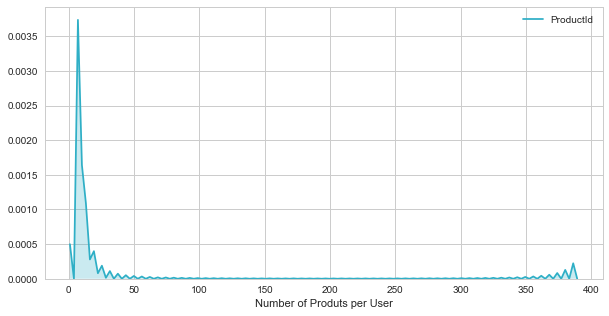

In [33]:
sns.set(rc={'figure.figsize': (10, 5)})
sns.set_style('whitegrid')
ax = sns.kdeplot(user_product_count, shade=True, color="#2FAFC6")
ax.set(xlabel='Number of Produts per User')
plt.show()

### The Products

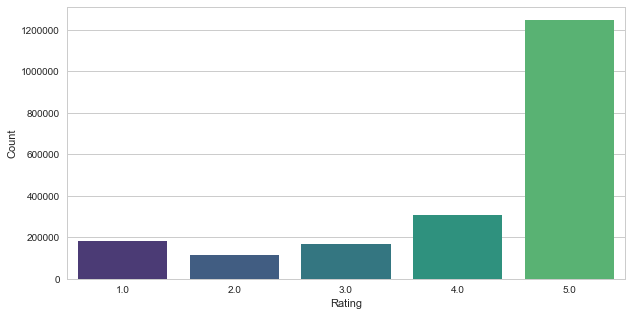

In [29]:
# Rating frequency


ax = sns.countplot(x='Rating', data=df, palette=sns.color_palette('viridis'))
ax.set(xlabel='Rating', ylabel='Count')
plt.show()

[Text(0.5,0,'Number of Votes per Product')]

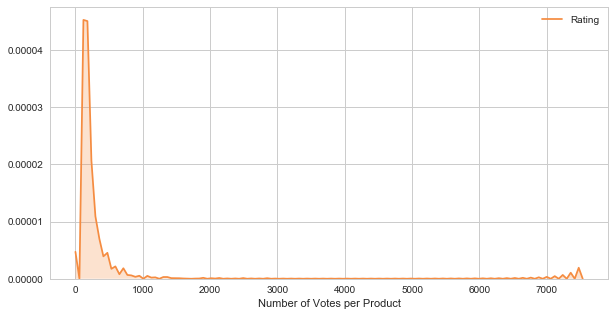

In [34]:
# Count of the number of rating  per product
product_rating_count = df.groupby('ProductId')['Rating'].count()
ax = sns.kdeplot(product_rating_count, shade=True, color="#F58C41")
ax.set(xlabel='Number of Votes per Product')

In [11]:
# Product arithmetic mean rating
product_rating = df.groupby('ProductId')['Rating'].mean()
product_rating.head()
#ax = sns.kdeplot(product_rating, shade=True, color="#800080")

ProductId
0205616461    5.0
0558925278    4.0
0733001998    4.0
0737104473    1.0
0762451459    5.0
Name: Rating, dtype: float64

In [12]:
# bayesian_mean

bayesian_mean = df.groupby('ProductId')['Rating'].mean()*['Rating'].count('Rating')/(['Rating'].count('Rating')+5)
bayesian_mean.head()

ProductId
0205616461    0.833333
0558925278    0.666667
0733001998    0.666667
0737104473    0.166667
0762451459    0.833333
Name: Rating, dtype: float64

In [13]:
# Un-Reliability factor

unreliability = df.groupby('ProductId')['Rating'].std(ddof = -1)
unreliability.head()

ProductId
0205616461    0.000000
0558925278    0.816497
0733001998    0.000000
0737104473    0.000000
0762451459    0.000000
Name: Rating, dtype: float64

In [14]:
unique_products_list = df.ProductId.unique()

data_model = pd.DataFrame({ 'Count': product_rating_count[unique_products_list], \
                            'Rating': product_rating[unique_products_list],\
                           'Bayesian_mean':bayesian_mean[unique_products_list],\
                          'Unreliability': unreliability[unique_products_list],
                           })
data_model['Normal_mean'] = data_model.Count*data_model.Unreliability
data_model['Product'] = unique_products_list
data_model = data_model.sort_values(by='Count', ascending=0)
print("Shape: %s" % str(data_model.shape))
data_model.head()


Shape: (249274, 6)


,Count,Rating,Bayesian_mean,Unreliability,Normal_mean,Product
ProductId,,,,,,
B001MA0QY2,7533,4.321386,0.720231,1.190225,8965.961772,B001MA0QY2
B0009V1YR8,2869,3.568839,0.594807,1.700139,4877.698149,B0009V1YR8
B0043OYFKU,2477,4.310456,0.718409,1.081852,2679.746800,B0043OYFKU
B0000YUXI0,2143,4.405040,0.734173,1.173484,2514.775726,B0000YUXI0
B003V265QW,2088,4.365421,0.727570,1.095747,2287.920457,B003V265QW


### Recommendation models

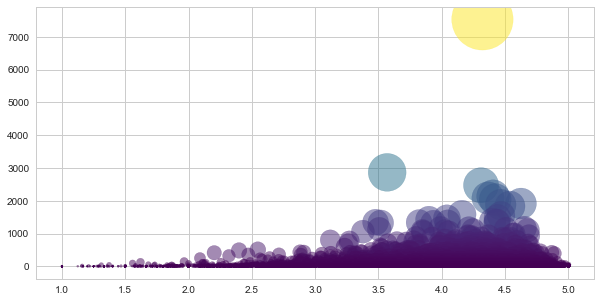

In [36]:
x = product_rating_count

# Make the plot
#plt.hexbin(data_model.Count, data_model.Rating, gridsize=12,mincnt=1, cmap='YlGnBu')
colors = data_model.Count
area = (data_model.Count)/2  # 0 to 15 point radii
plt.scatter(data_model.Rating,data_model.Count,c=colors,  s=area, alpha=0.5, cmap='viridis')

plt.show()

In [16]:
data_model_1000 = data_model[data_model.Count < 101]
print("Shape: %s" % str(data_model_1000.shape))
data_model_1000.head()

Shape: (246587, 6)


,Count,Rating,Bayesian_mean,Unreliability,Normal_mean,Product
ProductId,,,,,,
B004061V30,100,4.35,0.725000,1.047156,104.715551,B004061V30
B0053P6UTC,100,4.59,0.765000,0.902088,90.208779,B0053P6UTC
B0009F3M6A,100,4.68,0.780000,0.743020,74.302033,B0009F3M6A
B0089VK1ZG,100,2.79,0.465000,1.660818,166.081812,B0089VK1ZG
B000GFSVOQ,100,3.70,0.616667,1.551109,155.110947,B000GFSVOQ


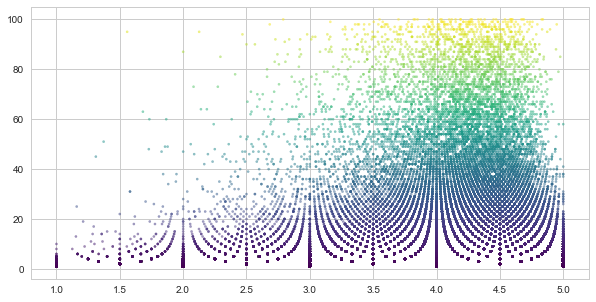

In [17]:
#plt.hexbin(data_model_1000.Count, data_model_1000.Bayesian_mean, gridsize=12,mincnt=1, cmap='YlGnBu')
plt.scatter( data_model_1000.Rating,data_model_1000.Count,c=data_model_1000.Count, s=5, alpha=0.5, cmap='viridis')
plt.show()

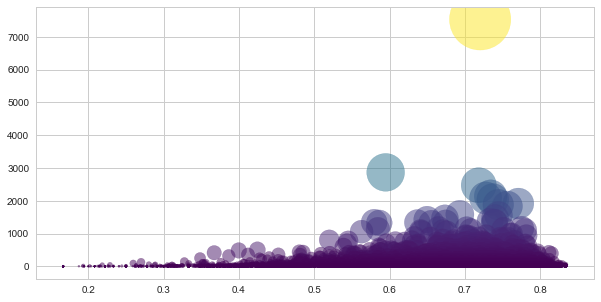

In [18]:
# Make the plot
#plt.hexbin(data_model.Count, data_model.Bayesian_mean, gridsize=12,mincnt=1, cmap='YlGnBu')
plt.scatter(data_model.Bayesian_mean,data_model.Count ,c=colors,  s=area, alpha=0.5, cmap='viridis')
plt.show()

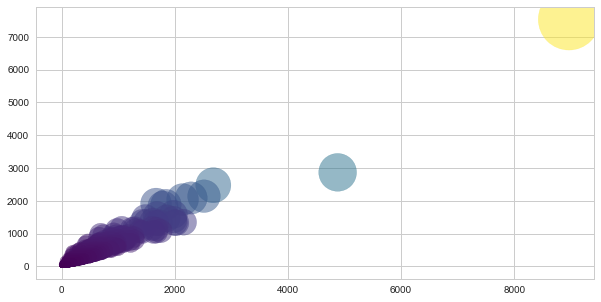

In [19]:
#plt.hexbin(data_model.Count, data_model.Normal_mean, gridsize=12,mincnt=1, cmap='YlGnBu')
plt.scatter(data_model.Normal_mean,data_model.Count ,c=colors,  s=area, alpha=0.5, cmap='viridis')
plt.show()

### Recommender System

In [37]:
#the function gets productId, rating amd a model and prints list of 5 recommended products
def recommendProducts(p,r,m):
    top5 = data_model.nlargest(5, m).drop(['Product'],axis=1)
    if data_model.Count[p] < 2 :
        return top5
    else:
        tempUserList = recommender_user[(recommender_user['ProductId_x'] == p) & (recommender_user['Rating'] == r)]
        if tempUserList.shape[0] < 2 :
            return top5
        else:
            tempUserList = tempUserList.drop(['Rating','Timestamp'],axis=1)
            tempProdList = pd.merge(tempUserList, recommender_user, how='left',left_on='UserId', right_on='UserId').drop_duplicates(subset=['UserId', 'ProductId_x_x'], keep='first', inplace=False) 
            prodList = pd.DataFrame({'Product':tempProdList.ProductId_x_y})
            prodList = pd.merge(prodList,data_model,how='left',left_on='Product', right_on='ProductId')
            prodList = prodList.drop(['Product_y'],axis=1).drop_duplicates(subset=['Product_x'], keep='first', inplace=False)
            return prodList.nlargest(5, m)
    #simUser = df.UserId[p]
    

In [38]:
#Recommed on user similarity base
Reclist = recommendProducts('B004CNRDBU',5,'Rating')
print(Reclist)

     Product_x  Count    Rating  Bayesian_mean  Unreliability  Normal_mean
14  B000WHYB1A     43  4.767442       0.794574       0.668690    28.753656
1   B0011UWXM6     32  4.718750       0.786458       0.706437    22.605979
8   B0018DAUKI    456  4.649123       0.774854       0.785341   358.115564
3   B00015GWQU     28  4.642857       0.773810       0.539111    15.095101
0   B0009R16O8     89  4.617978       0.769663       0.836735    74.469382


In [39]:
#Recommed on user similarity Bayesian mean base
Reclist = recommendProducts('B004CNRDBU',5,'Bayesian_mean')
print(Reclist)

     Product_x  Count    Rating  Bayesian_mean  Unreliability  Normal_mean
14  B000WHYB1A     43  4.767442       0.794574       0.668690    28.753656
1   B0011UWXM6     32  4.718750       0.786458       0.706437    22.605979
8   B0018DAUKI    456  4.649123       0.774854       0.785341   358.115564
3   B00015GWQU     28  4.642857       0.773810       0.539111    15.095101
0   B0009R16O8     89  4.617978       0.769663       0.836735    74.469382


In [23]:
#Recommed on user similarity Normal mean base
Reclist = recommendProducts('B004CNRDBU',5,'Normal_mean')
print(Reclist)

     Product_x  Count    Rating  Bayesian_mean  Unreliability  Normal_mean
10  B0000632EN    686  3.978134       0.663022       1.404231   963.302808
7   B00016XJ4M    845  4.492308       0.748718       1.020592   862.400047
9   B0002Z8HAI    680  4.442647       0.740441       1.019461   693.233205
8   B0018DAUKI    456  4.649123       0.774854       0.785341   358.115564
6   B0001EKTZQ    106  4.509434       0.751572       1.034411   109.647524


In [24]:
#Recommend on over-all top 5  mean rating base 
Reclist = recommendProducts('0205616461',3,'Rating')
print(Reclist)

            Count  Rating  Bayesian_mean  Unreliability  Normal_mean
ProductId                                                           
B004CNRDBU     58     5.0       0.833333            0.0          0.0
B001F0RBRE     41     5.0       0.833333            0.0          0.0
B004AI5756     38     5.0       0.833333            0.0          0.0
B00466VJ04     38     5.0       0.833333            0.0          0.0
B005V247N8     37     5.0       0.833333            0.0          0.0


In [25]:
#Recommend on over-all top 5 Bayesian mean base 
Reclist = recommendProducts('0205616461',3,'Bayesian_mean')
print(Reclist)

            Count  Rating  Bayesian_mean  Unreliability  Normal_mean
ProductId                                                           
B004CNRDBU     58     5.0       0.833333            0.0          0.0
B001F0RBRE     41     5.0       0.833333            0.0          0.0
B004AI5756     38     5.0       0.833333            0.0          0.0
B00466VJ04     38     5.0       0.833333            0.0          0.0
B005V247N8     37     5.0       0.833333            0.0          0.0


In [26]:
#Recommend on over-all top 5 Normal mean base 
Reclist = recommendProducts('0205616461',3,'Normal_mean')
print(Reclist)

            Count    Rating  Bayesian_mean  Unreliability  Normal_mean
ProductId                                                             
B001MA0QY2   7533  4.321386       0.720231       1.190225  8965.961772
B0009V1YR8   2869  3.568839       0.594807       1.700139  4877.698149
B0043OYFKU   2477  4.310456       0.718409       1.081852  2679.746800
B0000YUXI0   2143  4.405040       0.734173       1.173484  2514.775726
B003V265QW   2088  4.365421       0.727570       1.095747  2287.920457
